Ejemplo del uso de regresión lineal en redes neuronales
El archivo original puede ser encontrado en la siguiente ruta:
https://colab.research.google.com/drive/19jCsd1vSytbYoqOClp9B-HfQf5KSw44S
Para iniciar, se importan las librerías que serán usadas: pandas, mumpy, torch, matplotlib.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Se usará un dataset con datos cronológicos relacionados al precio del oro. Este dataset puede ser descargado de la siguiente ruta y cargado en un Data Frame de pandas llamado df.

In [3]:
#df = pd.read_csv("https://raw.githubusercontent.com/ralampay/pattern-recognition-course/master/notebooks/FINAL_USO.csv")
df = pd.read_csv("FINAL_USO.csv")

# El siguiente codigo examina las primeras 10 filas del data frame
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000
5,2011-12-22,156.350006,156.800003,155.330002,156.039993,156.039993,9888400,124.629997,125.400002,124.230003,...,51.770000,52.400002,49.656178,13179600,38.270000,38.549999,38.209999,38.279999,38.279999,5376800
6,2011-12-23,156.350006,156.490005,155.820007,156.309998,156.309998,3565100,125.669998,126.430000,125.410004,...,52.349998,52.790001,50.169365,4729000,38.470001,38.610001,38.369999,38.490002,38.490002,2162200
7,2011-12-27,155.080002,155.550003,154.539993,154.910004,154.910004,4918600,126.169998,126.820000,126.059998,...,51.680000,51.869999,49.295036,4786400,38.490002,39.209999,38.459999,39.060001,39.060001,7834100
8,2011-12-28,154.050003,154.259995,150.660004,151.029999,151.029999,16436100,126.510002,126.529999,124.730003,...,50.009998,50.060001,47.574883,14170400,38.880001,38.889999,38.189999,38.340000,38.340000,5654300
9,2011-12-29,149.089996,150.720001,148.270004,150.339996,150.339996,19812200,125.239998,126.250000,124.860001,...,49.220001,51.200001,48.658298,12196600,38.389999,38.459999,37.869999,38.410000,38.410000,8924300


Creamos la variable "attribute", la que estará relacionada con la columna del data frame que deseamos examinar. Podemos cambiar este valor y visualizar como varía el gráfico generado en la siguiente línea de código.

In [5]:
attribute = 'Low'

La variable "atribute" funciona como un filtro del data frame df.

<Axes: >

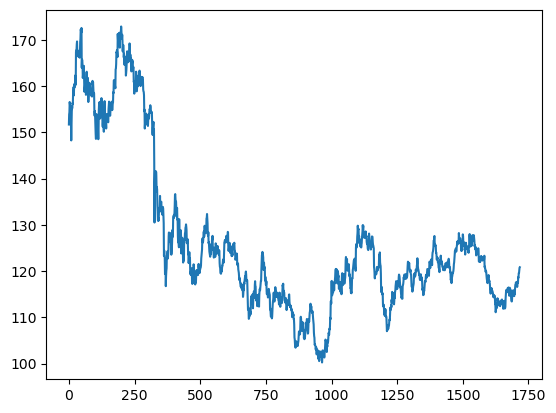

In [7]:
df[attribute].plot()

Extrayendo `X` e `Y`
Para definir nuestro conjunto de datos `X` y las etiquetas `Y`, primero necesitamos definir una longitud de secuencia (dada por la variable `sequence_length`) para definir la longitud de una única observación/patrón. Por ejemplo, si `sequence_length = 5` entonces una sola observación `x` son `5` mediciones consecutivas. También definimos una función `sliding_window()` que acepta todos los datos cronológicos como una matriz y la `sequence_length` para devolver dos valores: una matriz de observaciones `x` con longitud `sequence_length` y una matriz de `y` correspondiente a los siguientes valores de cada observación `x`. También mantendríamos una proporción para representar cuántas observaciones "x" y etiquetas "y" pertenecerán al conjunto de entrenamiento y cuáles pertenecerán al conjunto de prueba.

In [9]:
def sliding_window(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]

        x.append(_x)
        y.append([_y])

    return np.array(x), np.array(y)

# Cambie este valor para cambiar la longitud de la secuencia. Inicialmente configurado en 5
sequence_length = 2

# Cambie este valor para cambiar la cantidad de datos de entrenamiento que asignaríamos. Inicialmente fijado en 0,67
ratio = 0.8

Preparar datos de entrenamiento y pruebas

Esto divide los datos en lo siguiente:

* `train_x`: El conjunto de observaciones
* `train_y`: El valor predicho de cada observación
* `test_x`: El conjunto de observaciones de prueba para la predicción después del entrenamiento.
* `test_y`: El valor previsto de cada observación de prueba para su validación

In [11]:
data = df[attribute].values

x, y = sliding_window(data, sequence_length)

train_size = int(len(y) * ratio)
test_size = len(y) - train_size

# Convertir los conjuntos de datos en tensores para el cálculo que se realizará más adelante
data_x = Variable(torch.Tensor(np.array(x)))
data_y = Variable(torch.Tensor(np.array(y)))

train_x = Variable(torch.Tensor(np.array(x[0:train_size])))
train_y = Variable(torch.Tensor(np.array(y[0:train_size])))

test_x = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
test_y = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

Perceptrón multicapa

Este algoritmo es un ejemplo de una red neuronal completamente conectada implementada en Pytorch. 
Es una implementación bastante simple con solo un conjunto de neuronas para la capa de entrada, otro conjunto de neuronas para la 
capa oculta y otro conjunto para la capa de salida. Para configurar la red, defina los siguientes parámetros:
* `input_size`: La dimensionalidad de la capa de entrada
* `hidden_size`: La dimensionalidad de la capa oculta
* `output_size`: La dimensionalidad de `y` en la capa de salida

Para cambiar las funciones de activación del modelo, se puede consultar esta documentación:

https://pytorch.org/docs/stable/nn.function.html

Para obtener más información sobre cómo funciona `nn.Linear`, se puede consultar la siguiente documentación:

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [13]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # f(x) = a(f(x))
        x = F.relu(self.hidden(x))
        y = F.relu(self.output(x))

        return y

Configuración del modelo

Cambie estos valores antes de crear una instancia del modelo de perceptrón multicapa.

In [15]:
# Dado que la dimensionalidad de cada observación está definida por seequence_length, se usa ese valor
input_size = sequence_length

# Tamaño de la capa oculta
hidden_size = 1

# Tamaño de la capa de salida (Número de clases)
output_size = 1

# Instanciar el modelo
model = MultiLayerPerceptron(input_size, hidden_size, output_size)

Entrenamiento

Para entrenar una instancia del `MultilayerPerceptron`, primero tendremos que definir algunos parámetros de entrenamiento:
* `epochs`: cuántas veces se iteraría con el conjunto de datos para optimizar `W`
* `learning_rate`: Qué tan agresivo queremos buscar para un valor mínimo local.
* `criterion`: La función de pérdida para el entrenamiento
* `optimizer`: Nuestro solucionador de problemas para minimizar `W`

In [17]:

# Cambie esto para acortar o alargar el tiempo de entrenamiento.
epochs = 100

# Cambie esto para modificar la tasa de aprendizaje del optimizador.
learning_rate = 0.01

# Cambie esto a una implementación de función de pérdida. Inicialmente usaremos MSE (Error Cuadrático Medio).
criterion = torch.nn.MSELoss()

# Cambie esto para definir el optimizador.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

El proceso de entrenamiento real

In [19]:
for epoch in range(epochs):
    outputs = model.forward(train_x)

    optimizer.zero_grad()

    # Obtención de la función de pérdida.
    loss = criterion(outputs, train_y)

    loss.backward()

    optimizer.step()

    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 16829.60547
Epoch: 1, loss: 16822.17773
Epoch: 2, loss: 16520.69531
Epoch: 3, loss: 16123.08008
Epoch: 4, loss: 15654.46484
Epoch: 5, loss: 15148.20020
Epoch: 6, loss: 14618.58496
Epoch: 7, loss: 14073.40918
Epoch: 8, loss: 13517.54492
Epoch: 9, loss: 12954.37500
Epoch: 10, loss: 12386.45605
Epoch: 11, loss: 11815.86914
Epoch: 12, loss: 11244.40039
Epoch: 13, loss: 10673.65332
Epoch: 14, loss: 10105.13086
Epoch: 15, loss: 9540.26562
Epoch: 16, loss: 8980.45801
Epoch: 17, loss: 8427.08789
Epoch: 18, loss: 7881.52539
Epoch: 19, loss: 7345.14941
Epoch: 20, loss: 6819.32861
Epoch: 21, loss: 6305.43311
Epoch: 22, loss: 5804.82617
Epoch: 23, loss: 5318.85986
Epoch: 24, loss: 4848.86670
Epoch: 25, loss: 4396.14111
Epoch: 26, loss: 3961.93799
Epoch: 27, loss: 3547.45215
Epoch: 28, loss: 3153.80200
Epoch: 29, loss: 2782.01831
Epoch: 30, loss: 2433.01709
Epoch: 31, loss: 2107.58838
Epoch: 32, loss: 1806.37244
Epoch: 33, loss: 1529.84167
Epoch: 34, loss: 1278.28174
Epoch: 35, loss

Predicciones

Luego llamamos a `model.eval()` para congelar `W` e intentamos predecir `test_y`.

In [21]:
model.eval()
predictions = model(test_x).detach().numpy()

predictions = predictions.ravel()

predictions

array([119.80029 , 121.009346, 120.99546 , 120.621796, 119.694374,
       120.751114, 120.99942 , 121.44965 , 120.849075, 121.27987 ,
       121.07518 , 120.35641 , 122.32708 , 123.01689 , 123.13708 ,
       123.53097 , 124.13112 , 125.51076 , 125.52503 , 126.33265 ,
       126.461975, 124.991516, 124.86933 , 124.45521 , 124.56113 ,
       124.3041  , 122.93556 , 122.95779 , 122.09385 , 121.482956,
       121.89312 , 121.69122 , 121.83165 , 120.858604, 120.799904,
       120.49963 , 119.6908  , 119.688034, 119.368324, 118.848274,
       120.56546 , 121.32351 , 121.027985, 121.50875 , 122.27789 ,
       121.51153 , 120.704704, 120.55555 , 121.06011 , 120.35761 ,
       119.94904 , 119.96253 , 119.80465 , 119.21402 , 119.21124 ,
       119.37308 , 119.39132 , 119.83757 , 120.003006, 119.19458 ,
       119.674545, 119.80187 , 120.57856 , 120.680504, 119.94151 ,
       120.235825, 119.77887 , 120.23742 , 120.301674, 120.893906,
       120.04584 , 120.51033 , 121.15016 , 121.215614, 121.638

Observe los valores de la predicción

Tracemos tanto "test_y" como "predicciones" para ver qué tan lejos están entre sí.

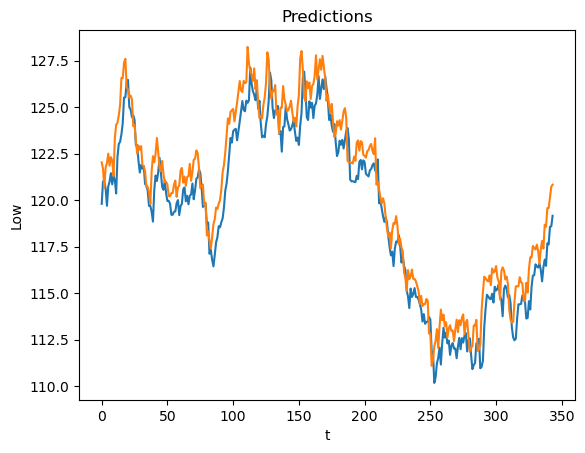

tensor([[122.0300],
        [121.6800],
        [120.6600],
        [121.7600],
        [122.0000],
        [122.5000],
        [121.8500],
        [122.3100],
        [122.1300],
        [121.2900],
        [123.3300],
        [124.0500],
        [124.1600],
        [124.5500],
        [125.1200],
        [126.5700],
        [126.5500],
        [127.3900],
        [127.5900],
        [126.0500],
        [125.9400],
        [125.5000],
        [125.6200],
        [125.4100],
        [123.9700],
        [124.0300],
        [123.1500],
        [122.4900],
        [122.9300],
        [122.7100],
        [122.9000],
        [121.8800],
        [121.8300],
        [121.5500],
        [120.7000],
        [120.7100],
        [120.4000],
        [119.7800],
        [121.5500],
        [122.3600],
        [122.0300],
        [122.5000],
        [123.3400],
        [122.5700],
        [121.7300],
        [121.5500],
        [122.1100],
        [121.3900],
        [120.9600],
        [120.9800],


In [23]:
x_axis_values = np.arange(0,len(predictions))

plt.title("Predictions")
plt.xlabel("t")
plt.ylabel(attribute)
plt.plot(x_axis_values, predictions)
plt.plot(x_axis_values, test_y)
plt.show()
print(test_y)